## Reservoir Computing

Reservoir computing is a simple method for training recurrent neural networks without backpropagation through time and the associated notorious vanishing and exploding gradient problems. The basic steps are:

1. Randomly initialize recurrent neural network weights.
2. Fix hidden connection weights.
3. Train linear output layer with linear regression.

More formally, the state of the recurrent neural network of $M$ neurons is given by its hidden activations $\mathbf{h} \in \mathbb{R}^{M}$, which are connected by randomly initialized and fixed matrix $\mathbf{W}_{\mathrm{h}}$.
An input sequence $\mathbf{X}_{1:\tau}$ is embedded by a linear map $\mathbf{W}_{\mathrm{i}}$ to the state $\mathbf{h}_\tau$:

$$
    \begin{split}
        \mathbf{h}_1 &= \sigma (\mathbf{W}_{\mathrm{h}} \mathbf{h}_0 +\mathbf{W}_{\mathrm{i}}\mathbf{x}_1) \\
    \vdots &\phantom{a}\hspace{1cm} \vdots\\
    \mathbf{h}_\tau &= \sigma (\mathbf{W}_{\mathrm{h}} \mathbf{h}_{\tau -1} + \mathbf{W}_{\mathrm{i}} \mathbf{x}_\tau).
    \end{split}
$$

Then, the reservoir can linearly predict the next input $\mathbf{x}_{\tau +1}$, based on the hidden state $\mathbf{h}_\tau$:

\begin{equation}
    \mathbf{\hat {x}}_{\tau +1} = \mathbf{W}_{\mathrm{o}} \mathbf{h}_\tau,
\end{equation}

with $\mathbf{W}_{\mathrm{o}}$ mapping from hidden activation to output.
Only the parameters of this output matrix $\mathbf{W}_{\mathrm{o}}$ are trained. Hence, the optimal values can be obtained analytically via ridge regression (with regularization parameter $\lambda$) as:

$$
    \mathbf{W}_{\mathrm{o}} = (\mathbf{H}^T\mathbf{H} + \lambda \mathbf{I})^{-1} \mathbf{H}^T \mathbf{X},
$$

where $\mathbf{H}$ are the hidden states, $\mathbf{I}$ the identity matrix, and $\mathbf{X}$ the targets of the regression.

## Example: Lorenz Attractor

In [2]:
from scipy import sparse

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = np.array([1.0, 1.0, 1.0])
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

In [5]:
radius = 0.6
sparsity = 0.01
input_dim = 3
reservoir_size = 1000
n_steps_prerun = 10
regularization = 1e-2
sequence = x_train

In [7]:
weights_hidden = sparse.random(reservoir_size,reservoir_size,density=sparsity)
eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
weights_hidden = weights_hidden/np.max(np.abs(eigenvalues)) * radius

weights_input = np.zeros((reservoir_size,input_dim))
q = int(reservoir_size/input_dim)
for i in range(0, input_dim):
    weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1
    
weights_output = np.zeros((input_dim, reservoir_size))

In [33]:
def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
    hidden = np.zeros((reservoir_size, 1))
    for t in range(n_steps_prerun):
        input = sequence[t].reshape(-1, 1)
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    return hidden

def augment_hidden(hidden):
    h_aug = hidden.copy()
    h_aug[::2] = pow(h_aug[::2], 2.0)
    return h_aug

hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
hidden_states = []
targets = []

for t in range(n_steps_prerun, len(sequence) - 1):
    input = np.reshape(sequence[t], (-1, 1))
    target = np.reshape(sequence[t + 1], (-1, 1))
    hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    hidden = augment_hidden(hidden)
    hidden_states.append(hidden)
    targets.append(target)

targets = np.squeeze(np.array(targets))
hidden_states = np.squeeze(np.array(hidden_states))

In [35]:
weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

In [36]:
def predict(sequence, n_steps_predict):
    hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
    input = sequence[n_steps_prerun].reshape((-1, 1))
    outputs = []

    for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
        hidden = augment_hidden(hidden)
        output = weights_output @ hidden
        input = output
        outputs.append(output)
    return np.array(outputs)

In [37]:
x_sim = predict(sequence, 4000)

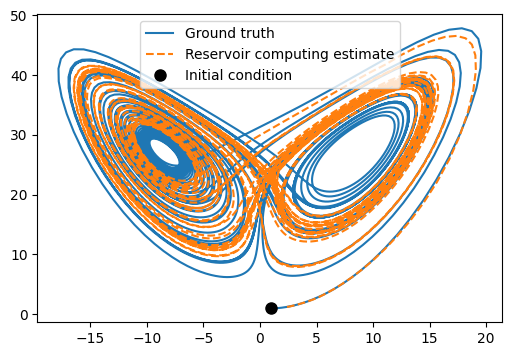

In [39]:
plt.figure(figsize=(6, 4))
plt.plot(x_train[:4000, 0], x_train[:4000, 2], label="Ground truth")
plt.plot(x_sim[:, 0], x_sim[:, 2],'--', label="Reservoir computing estimate")
plt.plot(x_train[0, 0], x_train[0, 2], "ko", label="Initial condition", markersize=8)

plt.legend()
plt.show()

In [40]:
def plot_dimension(dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

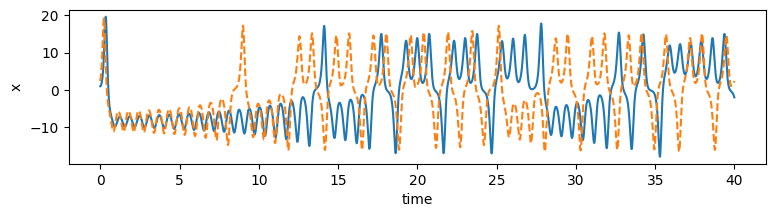

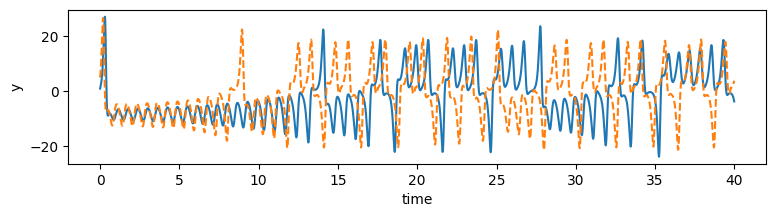

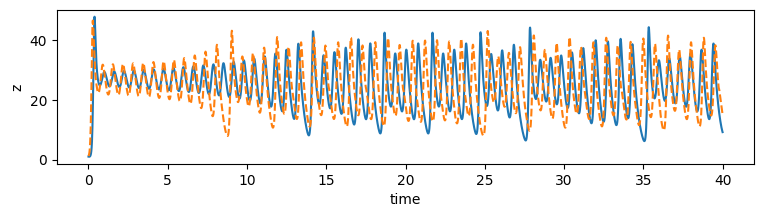

In [41]:
plot_dimension(0, 'x')
plot_dimension(1, 'y')
plot_dimension(2, 'z')